In [28]:
from spatial_statistics_tools import *
from process_images import *
from utilities import *
#from skimage import feature, restoration, segmentation, exposure, img_as_float
#from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_fill_holes
#from skimage.filters import gaussian
#from datetime import datetime

# TO DO:

1. How do different parameters, e.g. number and size of pixels influence K function?
2. Uniform pixels vs. one or more "Gaussian" clusters?
3. Visualisation autocorrelation
    1. How does it look, work in general?
    2. How is it affected by different numbers and sizes of pixels? How does it look when number of pixels increases from one or two to thousands (like in the cell images)? Seemingly, function smears out...; also: pixel size vs actual clusters
    3. Reason for position of the peaks; and: why no peak for the individual points?  --> t resolution (and how far pixels are apart) and in general, look at the autocorrelation functions
    4. Use images from internet for autocorrelation...
4. How does it directly compare to standard Ripley's K?
    1. Problems in edge correction
    2. Computation time
    3. Visual comparison
    
    
    
**Ideas/thoughts**:
- below certain level basically just random fluctuation...
- if more than just fluctuation, there should be clustering; not always directly visible, example of simulated Gaussian clusters
- peaks at different ts mean clustering/self-matching at different scales!

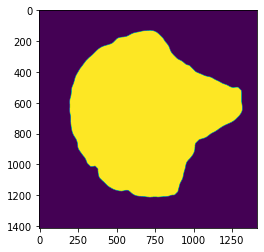

In [29]:
mask = np.load("mask2_clca.npy")
plt.imshow(mask)
plt.show()

In [276]:
def ripleys_K_fast(img_arr, mask, range_of_t, printout=False):
    """
    Computes Ripley's K function for a range of t. Utilizes FFT for fast computation of auto-correlation of the image.
    """
    K_values = []
    
    # assure datatype that does not cause errors
    arr = img_arr.astype('float32')
    # number of pixels in desired area
    N = np.sum(mask)
    # sum of all pixel intensities
    total_int = np.sum(arr)
    # here, assume A_pixel = 1, thus A=N
    lambda_ = total_int / N


    t1 = time()
    
    # full array for the auto-correlation of the input image
    # own implementation:
    #full_auto_corr = auto_correlation_fft(arr)
    # library function:
    full_auto_corr = signal.correlate(arr, arr, method='fft')
    
    # array whose elements are equal to their Euclidean distance from the center
    diff_xy = distance_arr(full_auto_corr)

    for t in range_of_t:
        # array containing the auto-correlation up to distance t
        auto_corr_t = cut_circle(full_auto_corr, radius=t, diff_xy=diff_xy)
        
        # sum over all elements
        sum_ = np.sum(auto_corr_t)
        
        K = sum_ * 1/lambda_ * 1/N
        K_values.append(K)
    
    t2 = time()
    if printout:
        print(f"Completed in {(t2-t1):.2f} seconds")
    
    return K_values, full_auto_corr


def truncated_gaussian(mean, sigma, N=1):
    """
    ...
    """
    return np.round(np.random.normal(mean, sigma, N))


def generate_random_cell_image(mask, pixel_size=1, pixel_int=10, n_pixels=1000, n_pixels_cluster=0, cluster_size=100, cluster_pos=(0,0), desired_int=2000000000, binary=False):
    """
    ...
    """
    x_lim, y_lim = mask.shape
    arr = np.zeros(mask.shape)
    
    if n_pixels_cluster > n_pixels:
        print("Error! Total number of pixels n_pixels must be larger than or equal to n_pixels_cluster!")
        return

    n_pixels_uniform = n_pixels - n_pixels_cluster

    # define size of cluster := FWHM = 2.355 * sigma (for Gaussian)
    sigma = cluster_size/2.355
    mean_x, mean_y = cluster_pos

    # generate random pixels in the area specified by cell mask
    count=0
    while count<n_pixels_uniform:
        rnd_x = np.random.randint(x_lim)
        rnd_y = np.random.randint(y_lim)
        if mask[rnd_x, rnd_y] == 1 and arr[rnd_x, rnd_y] == 0:
            arr[rnd_x, rnd_y] = pixel_int #+ arr[rnd_x, rnd_y]
            count+=1

    # generate additional pixels around a defined cluster 
    count=0
    while count<n_pixels_cluster:
        rnd_x = int(truncated_gaussian(mean_x+x_lim/2, sigma))
        rnd_y = int(truncated_gaussian(mean_y+y_lim/2, sigma))
        if (rnd_x < x_lim) and (rnd_y < y_lim):
            if mask[rnd_x, rnd_y] == 1 and arr[rnd_x, rnd_y] == 0:
                arr[rnd_x, rnd_y] = pixel_int #+ arr[rnd_x, rnd_y]    
                count+=1

    if np.sum(arr) != pixel_int*n_pixels:
        print("Error! Amount of points in resulting image is not equal to specified number of points!")
        return

    # slightly dilate and blur the pixels to enlarge them
    arr = binary_dilation(arr, iterations=pixel_size)
    arr = gaussian(arr, sigma=3)
    
    # if binary, then image will only have values 1 or 0
    if binary:
        img_real = exposure.equalize_hist(img_real)>0.97

    img_csr = scale_image(mask, desired_int) 
    img_real = scale_image(arr, desired_int)
    
    return img_real, img_csr


def get_K_diff(mask, img_real, img_csr, range_of_t, printout=True):
    """
    ...
    """
    K_values_real, corr_real = ripleys_K_fast(img_real, mask, range_of_t, printout)
    K_values_csr, corr_csr = ripleys_K_fast(img_csr, mask, range_of_t, printout)
    K_diff = np.array(K_values_real) - np.array(K_values_csr)
    return K_diff, K_values_real, K_values_csr, corr_real, corr_csr

In [314]:
pixel_size=1
pixel_int=1
n_pixels=100
n_pixels_cluster=0#500
cluster_size=200
cluster_pos=(0,0)
desired_int=1000000
binary=False

#range_of_t = list(range(20)) + list(np.linspace(20, 500, 60))
range_of_t = np.linspace(1, 1200, 40)

folder = "toy_data_results"

for i in range(0,20):
    
    cluster_pos=(-200+20*i,-200+20*i)
    n_total = 2000 #- 400*i
    n_pixels = int(n_total * 0.7)
    n_pixels_cluster = int(n_total * 0.3)
    
    filename = f"cluster_pos_corr_log_test_{i}.pdf"
    path = os.path.join(folder, filename)
    print(f"Creating {filename}...")
      
    img_real, img_csr = generate_random_cell_image(mask, pixel_size, pixel_int, n_pixels, n_pixels_cluster, cluster_size, cluster_pos, desired_int, binary)
     # np.arange(1, 1200, 40)
    K_diff, K_values_real, K_values_csr, corr_real, corr_csr = get_K_diff(mask, img_real, img_csr, range_of_t, True)

    title = f"pixel distribution: uniform, pixel size={pixel_size}, pixel int={pixel_int}, no. pixels={n_pixels}, n_pixels_cluster={n_pixels_cluster}, cluster_size={cluster_size}, pixel sum per image={desired_int}"
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    ax[0][0].imshow(img_real)
  #  ax[1].plot(range_of_t, K_values_real)
   # ax[1].plot(range_of_t, K_values_csr)
    vmin = np.min(corr_real)
    vmax = np.max(corr_real)

    ax[0][1].plot(range_of_t, K_diff)
    ax[0][1].set_xlabel("t")
    ax[0][1].set_ylabel("K(t)")
    ax[0][1].set_ylim(top=250000)
    ax[1][0].imshow(corr_real, vmin=vmin, vmax=vmax)
    ax[1][0].set_title("Autocorr. real image")
    ax[1][1].matshow(corr_real-corr_csr, norm=LogNorm())    #imshow(corr_csr, vmin=vmin, vmax=vmax)    
    ax[1][1].set_title("Autocorr. real-CSR image (log scale)")
    fig.suptitle(title)
    plt.savefig(path)
    #plt.show()
    plt.close()
    
   # plt.plot(range_of_t[:-1], np.diff(K_diff)/np.diff(range_of_t))
   # plt.show()
print("Completed!")

Creating cluster_pos_corr_log_test_0.pdf...
Completed in 3.09 seconds
Completed in 2.93 seconds
Creating cluster_pos_corr_log_test_1.pdf...
Completed in 3.28 seconds
Completed in 2.97 seconds
Creating cluster_pos_corr_log_test_2.pdf...
Completed in 3.25 seconds
Completed in 3.28 seconds
Creating cluster_pos_corr_log_test_3.pdf...
Completed in 3.21 seconds
Completed in 3.01 seconds
Creating cluster_pos_corr_log_test_4.pdf...
Completed in 3.28 seconds
Completed in 3.09 seconds
Creating cluster_pos_corr_log_test_5.pdf...
Completed in 3.18 seconds
Completed in 2.99 seconds
Creating cluster_pos_corr_log_test_6.pdf...
Completed in 3.26 seconds
Completed in 2.98 seconds
Creating cluster_pos_corr_log_test_7.pdf...
Completed in 3.22 seconds
Completed in 2.99 seconds
Creating cluster_pos_corr_log_test_8.pdf...
Completed in 3.54 seconds
Completed in 2.95 seconds
Creating cluster_pos_corr_log_test_9.pdf...
Completed in 3.47 seconds
Completed in 2.96 seconds
Creating cluster_pos_corr_log_test_10.pd

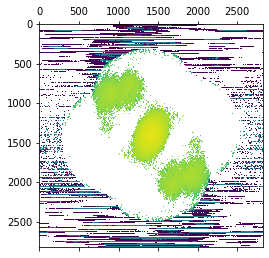

In [312]:
from pylab import figure, cm
from matplotlib.colors import LogNorm
#plt.imshow(corr_real-corr_csr)
plt.matshow(corr_real-corr_csr, norm=LogNorm())
#plt.yticks(auto_corr_ticks)
plt.show()

In [299]:
auto_corr_ticks_wrong = list(range(0, y))
auto_corr_ticks = list(range(-int(y/2),0))+[0]+list(range(0,int(y/2)))

In [300]:
len(auto_corr_ticks_wrong)

2823

In [280]:
vmin = np.min(corr_real)
vmax = np.max(corr_real)
print(vmin, vmax)

vmin = np.min(corr_csr)
vmax = np.max(corr_csr)
print(vmin, vmax)

-0.6320988 8803131.0
-0.22123456 1274734.6


In [261]:
for i in range(9):
    
    n_total = 4000 - 400*i
    n_pixels = int(n_total * 0.7)
    n_pixels_cluster = int(n_total * 0.3)
    
    print(n_pixels_cluster/n_pixels)

0.42857142857142855
0.42857142857142855
0.42857142857142855
0.42879019908116384
0.42857142857142855
0.42857142857142855
0.42857142857142855
0.42857142857142855
0.42857142857142855


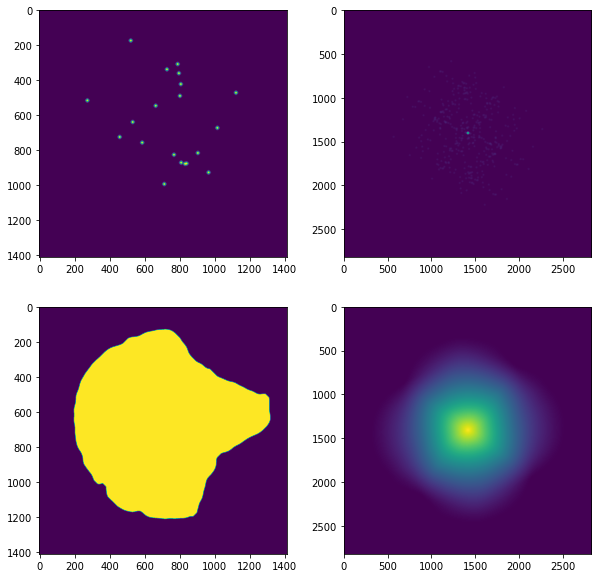

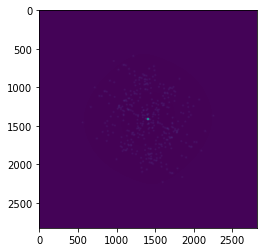

In [24]:
pixel_size=1
pixel_int=1
n_pixels=2000
n_pixels_cluster=700
cluster_size=200
cluster_pos=(0,0)
desired_int=1000000
binary=False

arr1, mask1 = generate_cell_image_uniform(mask, pixel_size, pixel_int, n_pixels, desired_int, binary)

arr1 = scale_image(arr1, desired_int)
mask1 = scale_image(mask1, desired_int)

auto_corr1 = signal.correlate(arr1.astype('float32'), arr1.astype('float32'), method='fft')
auto_corr_mask1 = signal.correlate(mask1.astype('float32'), mask1.astype('float32'), method='fft')

#arr2, _ = generate_cell_image_uniform(mask, pixel_size, pixel_int, n_pixels, desired_int, binary)
#auto_corr2 = signal.correlate(arr2.astype('float32'), arr2.astype('float32'), method='fft')


fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0][0].imshow(arr1)
ax[0][1].imshow(auto_corr1)
ax[1][0].imshow(mask1)
ax[1][1].imshow(auto_corr_mask1)
plt.show()

plt.imshow(auto_corr1-auto_corr_mask1)
plt.show()

For more randomness, the autocorrelation is more uniform in all directions...

Last image is what we sum over!
Observation(???): middle point is so high, that if the points are not that far apart, K_diff function keeps on rising.
Could we perhaps scale every product by the square of the average intensity? To get rid of the squared stuff or smth.

Is there a better metric to compare the autocorrelations than simply the K function plot?

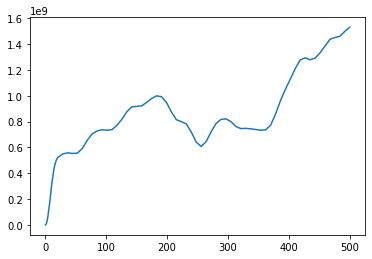

In [27]:
# array whose elements are equal to their Euclidean distance from the center
diff_xy = distance_arr(auto_corr1)

range_of_t = list(range(20)) + list(np.linspace(20, 500, 60))

K_cell = []
K_mask = []

for t in range_of_t:
    # array containing the auto-correlation up to distance t
    auto_corr_t = cut_circle(auto_corr1, radius=t, diff_xy=diff_xy)
    auto_corr_mask_t = cut_circle(auto_corr_mask1, radius=t, diff_xy=diff_xy)
    
    K_cell.append(np.sum(auto_corr_t))
    K_mask.append(np.sum(auto_corr_mask_t))
    
#plt.plot(range_of_t, K_cell)
#plt.plot(range_of_t, K_mask)
plt.plot(range_of_t, np.array(K_cell)-np.array(K_mask))
plt.show()

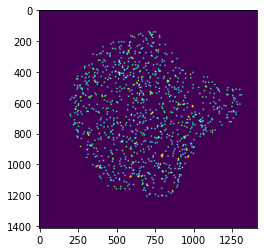

In [53]:
pixel_size=1 
pixel_int=10 
n_pixels=1000

img_real, img_csr = generate_cell_image_uniform(mask, pixel_size, pixel_int, n_pixels)


plt.imshow(exposure.equalize_hist(img_real)>0.97)
plt.show()

In [66]:
np.mean(full_auto1)

1254.8099

In [47]:
exposure.equalize_hist(img_real)>0.9

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [43]:
def generate_cell_image_uniform(mask, pixel_size=1, pixel_int=10, n_pixels=1000, desired_int=2000000000, binary=False):
    """
    ...
    """
    x_lim, y_lim = mask.shape
    arr = np.zeros(mask.shape)

    # generate random pixels in the area specified by cell mask
    count=0
    while count<n_pixels:
        rnd_x = np.random.randint(x_lim)
        rnd_y = np.random.randint(y_lim)
        if mask[rnd_x, rnd_y] == 1:
            arr[rnd_x, rnd_y] = pixel_int
            count+=1

    # slightly dilate and blur the pixels to enlarge them
    arr = binary_dilation(arr, iterations=pixel_size)
    arr = gaussian(arr, sigma=3)
    
    if binary:
        img_real = exposure.equalize_hist(img_real)>0.97
        
    img_csr = scale_image(mask, desired_int) 
    img_real = scale_image(arr, desired_int)
    
    return img_real, img_csr

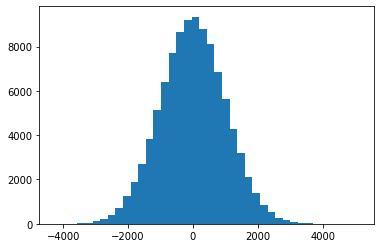

In [88]:
gauss_cont = np.random.normal(0, 1000, 100000)
gauss_trunc = np.round(gauss_cont)
plt.hist(gauss_trunc, bins=40)
plt.show()

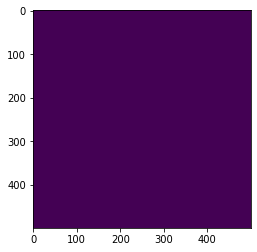

In [74]:
base = np.zeros((500,500))
plt.imshow(base)
plt.show()

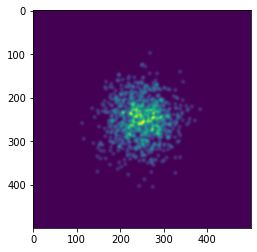

In [105]:



cluster_pos = (0,0)
n_pixels_cluster = 1000
pixel_int = 10
cluster_size = 100
pixel_size = 1


arr = np.zeros((500,500))

x_dim, y_dim = arr.shape

mean_x, mean_y = cluster_pos

# size of cluster := FWHM = 2.355 * sigma (for Gaussian)
sigma = cluster_size/2.355


for i in range(n_pixels_cluster):
    
    rnd_x = int(truncated_gaussian(mean_x+x_dim/2, sigma))
    rnd_y = int(truncated_gaussian(mean_y+y_dim/2, sigma))
    
    if rnd_x < x_dim and rnd_y < y_dim:
    #print(rnd_x)
        arr[rnd_x, rnd_y] = pixel_int

    
# slightly dilate and blur the pixels to enlarge them
arr = binary_dilation(arr, iterations=pixel_size)
arr = gaussian(arr, sigma=3)

plt.imshow(arr)
plt.show()